TSNE Check Embeddings Performance

提取向量和家族資訊...
原始資料筆數：17043
篩選後資料筆數：6433


Processing Gpickle files: 100%|██████████| 6433/6433 [00:02<00:00, 2309.75it/s]


總共載入 6391 個向量
數據量較大，進行抽樣以加速 t-SNE 運算。
執行 t-SNE 並創建視覺化...


/tmp/ipykernel_4021840/228253094.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  family_colors = plt.cm.get_cmap('tab10', len(set(families)))


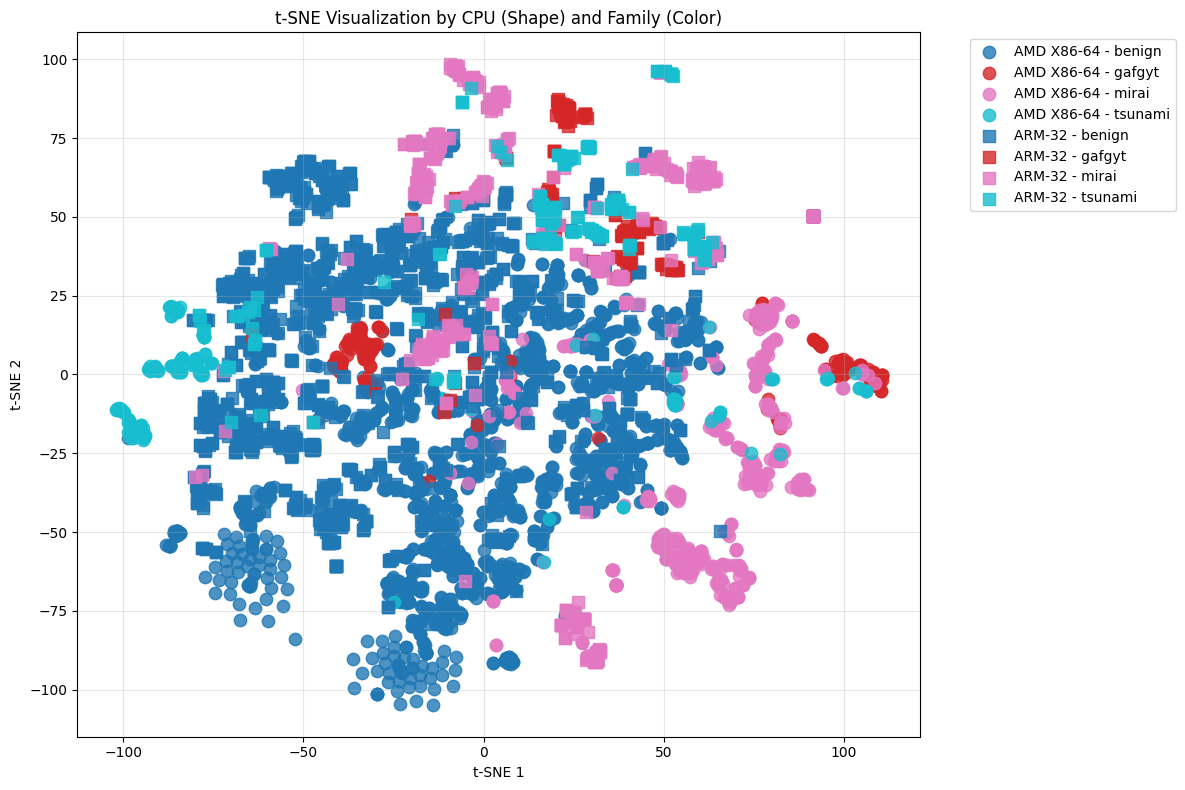


Numerical Analysis: Cluster Centroids & Distances

Cluster Centroid Coordinates (t-SNE 2D):
                      t-SNE 1    t-SNE 2
AMD X86-64-benign   -0.140000 -28.820000
AMD X86-64-gafgyt   29.190001   1.590000
AMD X86-64-mirai    61.660000 -27.780001
AMD X86-64-tsunami -52.419998  -3.250000
ARM-32-benign      -29.209999   9.170000
ARM-32-gafgyt       32.939999  52.880001
ARM-32-mirai        15.820000  40.200001
ARM-32-tsunami      15.660000  48.299999

Euclidean Distance Between Clusters:
                    AMD X86-64-benign  AMD X86-64-gafgyt  AMD X86-64-mirai  \
AMD X86-64-benign            0.000000          42.250000         61.799999   
AMD X86-64-gafgyt           42.250000           0.000000         43.779999   
AMD X86-64-mirai            61.799999          43.779999          0.000000   
AMD X86-64-tsunami          58.209999          81.760002        116.690002   
ARM-32-benign               47.840000          58.889999         98.089996   
ARM-32-gafgyt               88.1

In [ ]:
import pandas as pd
import pickle
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from typing import List, Union
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances

# 忽略 tqdm 的 FutureWarning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

def extract_vectors_from_gpickle(csv_file_path: Union[str, Path], root_dir: Union[str, Path], cpu_filter: List[str]):
    """
    從 CSV 讀取檔案資訊，並從 .gpickle 檔案中提取向量
    """
    root_path = Path(root_dir)
    df = pd.read_csv(csv_file_path)
    
    filtered_df = df[df['CPU'].isin(cpu_filter)]
    
    print(f"原始資料筆數：{len(df)}")
    print(f"篩選後資料筆數：{len(filtered_df)}")
    
    vectors = []
    cpus = []
    families = []
    
    for _, row in tqdm(filtered_df.iterrows(), total=len(filtered_df), desc="Processing Gpickle files"):
        file_name = row['file_name']
        cpu = row['CPU']
        family = row['family']
        
        prefix = file_name[:2]
        path = root_path / prefix / f"{file_name}.gpickle"
        
        if path.exists():
            try:
                with open(path, "rb") as fp:
                    data = pickle.load(fp)
                
                if 'node_embeddings' in data and data['node_embeddings']:
                    node_embeddings = data['node_embeddings']
                    node_vectors = [np.array(emb) for emb in node_embeddings.values() if len(emb) == 256]
                    
                    if node_vectors:
                        avg_vector = np.mean(node_vectors, axis=0)
                        vectors.append(avg_vector)
                        cpus.append(cpu)
                        families.append(family)
            except Exception as e:
                tqdm.write(f"[Error] Load Gpickle Failed {path}: {e}")
            
    return np.array(vectors), cpus, families

def visualize_and_analyze_tsne(vectors, cpus, families):
    """
    執行 t-SNE，視覺化並輸出數值化分析報告。
    """
    # t-SNE 降維
    tsne = TSNE(n_components=2, random_state=42, perplexity=15)
    vectors_2d = tsne.fit_transform(vectors)
    
    # 視覺化
    cpu_markers = {'ARM-32': 's', 'AMD X86-64': 'o'}
    family_colors = plt.cm.get_cmap('tab10', len(set(families)))
    family_color_map = {family: family_colors(i) for i, family in enumerate(sorted(list(set(families))))}
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    unique_cpus = sorted(list(set(cpus)))
    unique_families = sorted(list(set(families)))

    for cpu in unique_cpus:
        for family in unique_families:
            mask = [(c == cpu and f == family) for c, f in zip(cpus, families)]
            if any(mask):
                current_vectors = vectors_2d[mask]
                ax.scatter(current_vectors[:, 0], current_vectors[:, 1],
                            c=[family_color_map.get(family)], marker=cpu_markers.get(cpu, 'o'),
                            alpha=0.8, s=80, label=f'{cpu} - {family}')
    
    ax.set_title('t-SNE Visualization by CPU (Shape) and Family (Color)')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 數值化分析
    print("\n" + "="*50)
    print("Numerical Analysis: Cluster Centroids & Distances")
    print("="*50)
    
    cluster_centroids = {}
    labels = []
    
    for cpu in unique_cpus:
        for family in unique_families:
            mask = [(c == cpu and f == family) for c, f in zip(cpus, families)]
            if any(mask):
                current_vectors = vectors_2d[mask]
                centroid = np.mean(current_vectors, axis=0)
                cluster_label = f'{cpu}-{family}'
                cluster_centroids[cluster_label] = centroid
                labels.append(cluster_label)
    
    centroids_array = np.array(list(cluster_centroids.values()))
    
    # 計算歐式距離矩陣
    distances = euclidean_distances(centroids_array)
    
    # 建立 DataFrame 進行視覺化輸出
    distance_df = pd.DataFrame(distances, index=labels, columns=labels).round(2)
    
    print("\nCluster Centroid Coordinates (t-SNE 2D):")
    centroids_df = pd.DataFrame(centroids_array, index=labels, columns=['t-SNE 1', 't-SNE 2']).round(2)
    print(centroids_df)
    
    print("\nEuclidean Distance Between Clusters:")
    print(distance_df)

# 主程式
def main():
    csv_file_path = "/home/tommy/Project/PcodeBERT/dataset/csv/base_dataset_filtered_v2.csv"
    gpickle_dir = "/home/tommy/Project/PcodeBERT/outputs/embeddings"
    
    target_cpus = ['AMD X86-64', 'ARM-32']

    print("提取向量和家族資訊...")
    vectors, cpus, families = extract_vectors_from_gpickle(
        csv_file_path, gpickle_dir, target_cpus
    )
    
    print(f"總共載入 {len(vectors)} 個向量")
    if len(vectors) > 0:
        if len(vectors) > 5000:
            print("數據量較大，進行抽樣以加速 t-SNE 運算。")
            import random
            sample_size = 5000
            indices = random.sample(range(len(vectors)), sample_size)
            vectors_sampled = vectors[indices]
            cpus_sampled = [cpus[i] for i in indices]
            families_sampled = [families[i] for i in indices]
        else:
            vectors_sampled = vectors
            cpus_sampled = cpus
            families_sampled = families
        
        print("執行 t-SNE 並創建視覺化...")
        visualize_and_analyze_tsne(vectors_sampled, cpus_sampled, families_sampled)
    else:
        print("沒有找到符合條件的數據。")

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import torch
import os
import pickle
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
import warnings

# 忽略 scikit-learn 的 FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

def get_gnn_config():
    BASE_PATH = "/home/tommy/Project/PcodeBERT"
    
    config = {
        "source_cpus": ["AMD X86-64"],     
        "target_cpus": ["ARM-32"],        
        
        "csv_path": f"{BASE_PATH}/dataset/csv/base_dataset_filtered_v2.csv",
        "graph_dir": f"{BASE_PATH}/outputs/embeddings",
        "cache_file": f"{BASE_PATH}/outputs/cache/gnn_data_by_family_label.pkl",
        "model_output_dir": f"{BASE_PATH}/outputs/models/gnn",
        
        "batch_size": 32,
        "hidden_channels": 64,
        "learning_rate": 0.01,
        "epochs": 200,
        "patience": 20,
        
        "seeds": [42, 123, 2025, 31415, 8888],
        "device": "cuda"
    }
    
    return config

def load_graphs_from_df(df, graph_dir, label_col='label'):
    """
    從 DataFrame 載入圖資料。
    新增了 label_col 參數來決定使用哪一欄作為標籤。
    """
    graphs = []
    labels = []
    
    for _, row in df.iterrows():
        file_name = row['file_name']
        prefix = file_name[:2]
        label = row[label_col]
        graph_path = Path(graph_dir) / prefix / f"{file_name}.gpickle"

        if not graph_path.exists():
            continue
            
        with open(graph_path, 'rb') as f:
            data = pickle.load(f)
        
        node_embeddings = data['node_embeddings']
        if not node_embeddings:
            continue
        
        embeddings = [list(emb) for emb in node_embeddings.values()]
        x = torch.tensor(embeddings, dtype=torch.float)
        
        num_nodes = len(embeddings)
        edge_list = []
        for i in range(num_nodes - 1):
            edge_list.extend([[i, i+1], [i+1, i]])
        
        if edge_list:
            edge_index = torch.tensor(edge_list, dtype=torch.long).t()
        else:
            edge_index = torch.tensor([[0], [0]], dtype=torch.long)
        
        graph_data = Data(x=x, edge_index=edge_index)
        graphs.append(graph_data)
        labels.append(label)
    
    return graphs, labels

def load_cross_arch_data_with_family_label(csv_path, graph_dir, source_cpus, target_cpus, cache_file, val_size=0.2, random_state=42, force_reload=False):
    """
    載入跨架構的圖資料，並以 'family' 作為標籤。
    """
    if force_reload and os.path.exists(cache_file):
        os.remove(cache_file)
    
    if os.path.exists(cache_file):
        print(f"Loading cached data from: {cache_file}")
        with open(cache_file, 'rb') as f:
            cached_data = pickle.load(f)
        return (cached_data['train_graphs'], 
                cached_data['val_graphs'],
                cached_data['test_graphs'], 
                cached_data['label_encoder'], 
                cached_data['num_classes'])
    
    print("Loading CSV data...")
    df = pd.read_csv(csv_path)
    
    train_df = df[df['CPU'].isin(source_cpus)]
    test_df = df[df['CPU'].isin(target_cpus)]
    
    print(f"Training data: {len(train_df)} samples (architectures: {source_cpus})")
    print(f"Test data: {len(test_df)} samples (architectures: {target_cpus})")
    
    train_graphs, train_labels = load_graphs_from_df(train_df, graph_dir, label_col='family')
    test_graphs, test_labels = load_graphs_from_df(test_df, graph_dir, label_col='family')
    
    train_graphs, val_graphs, train_labels, val_labels = train_test_split(
        train_graphs, train_labels, test_size=val_size, 
        stratify=train_labels, random_state=random_state
    )
    
    label_encoder = LabelEncoder()
    all_labels = train_labels + val_labels + test_labels
    label_encoder.fit(all_labels)
    
    encoded_train_labels = label_encoder.transform(train_labels)
    encoded_val_labels = label_encoder.transform(val_labels)
    encoded_test_labels = label_encoder.transform(test_labels)
    
    num_classes = len(label_encoder.classes_)
    
    for i, data in enumerate(train_graphs):
        data.y = torch.tensor(encoded_train_labels[i], dtype=torch.long)
        
    for i, data in enumerate(val_graphs):
        data.y = torch.tensor(encoded_val_labels[i], dtype=torch.long)
        
    for i, data in enumerate(test_graphs):
        data.y = torch.tensor(encoded_test_labels[i], dtype=torch.long)

    os.makedirs(os.path.dirname(cache_file), exist_ok=True)
    cache_data = {
        'train_graphs': train_graphs,
        'val_graphs': val_graphs,
        'test_graphs': test_graphs,
        'label_encoder': label_encoder,
        'num_classes': num_classes
    }
    
    with open(cache_file, 'wb') as f:
        pickle.dump(cache_data, f)
    
    print(f"Data has been cached to: {cache_file}")
    return train_graphs, val_graphs, test_graphs, label_encoder, num_classes

def analyze_dataset_by_family(graphs, label_encoder):
    """
    Analyzes the node distribution for each family and returns a dictionary of stats.
    """
    family_stats = {}
    if not graphs:
        return family_stats

    # Group graphs by family
    family_groups = defaultdict(list)
    for g in graphs:
        family = label_encoder.inverse_transform([int(g.y)])[0]
        family_groups[family].append(g.num_nodes)

    for family, node_counts in family_groups.items():
        family_stats[family] = {
            "Total Graphs": len(node_counts),
            "Avg Nodes": np.mean(node_counts),
            "Median Nodes": np.median(node_counts),
            "Max Nodes": np.max(node_counts),
            "Min Nodes": np.min(node_counts)
        }
    return family_stats

def compare_datasets(train_graphs, val_graphs, test_graphs, label_encoder):
    """
    Compares key statistics of training, validation, and test datasets.
    """
    # First, print the overall comparison report
    train_stats = analyze_dataset_by_family(train_graphs, label_encoder)
    test_stats = analyze_dataset_by_family(test_graphs, label_encoder)

    all_families = sorted(list(set(train_stats.keys()) | set(test_stats.keys())))

    print("\n" + "="*50)
    print("Family-wise Node Count Comparison")
    print("="*50)

    for family in all_families:
        train_data = train_stats.get(family, {"Total Graphs": 0, "Avg Nodes": 0, "Median Nodes": 0, "Max Nodes": 0, "Min Nodes": 0})
        test_data = test_stats.get(family, {"Total Graphs": 0, "Avg Nodes": 0, "Median Nodes": 0, "Max Nodes": 0, "Min Nodes": 0})
        
        print(f"\n--- Family: {family} ---")
        
        comparison_df = pd.DataFrame({
            "Metric": ["Total Graphs", "Avg Nodes", "Median Nodes", "Max Nodes", "Min Nodes"],
            "Training Set": [train_data["Total Graphs"], f"{train_data['Avg Nodes']:.2f}", train_data["Median Nodes"], train_data["Max Nodes"], train_data["Min Nodes"]],
            "Test Set": [test_data["Total Graphs"], f"{test_data['Avg Nodes']:.2f}", test_data["Median Nodes"], test_data["Max Nodes"], test_data["Min Nodes"]]
        })
        print(comparison_df.to_string(index=False))

# Main execution
if __name__ == "__main__":
    gnn_config = get_gnn_config()
    
    train_graphs, val_graphs, test_graphs, label_encoder, num_classes = load_cross_arch_data_with_family_label(
        csv_path=gnn_config["csv_path"],
        graph_dir=gnn_config["graph_dir"],
        source_cpus=gnn_config["source_cpus"],
        target_cpus=gnn_config["target_cpus"],
        cache_file=gnn_config["cache_file"],
        force_reload=False
    )

    compare_datasets(train_graphs, val_graphs, test_graphs, label_encoder)

/home/tommy/miniconda3/envs/PcodeBERT/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading CSV data...
Training data: 3224 samples (architectures: ['AMD X86-64'])
Test data: 3209 samples (architectures: ['ARM-32'])
Data has been cached to: /home/tommy/Project/PcodeBERT/outputs/cache/gnn_data_by_family_label.pkl

Family-wise Node Count Comparison

--- Family: benign ---
      Metric Training Set Test Set
Total Graphs         1592     1961
   Avg Nodes       167.52   261.66
Median Nodes         28.0     44.0
   Max Nodes         8543     4718
   Min Nodes            2        1

--- Family: gafgyt ---
      Metric Training Set Test Set
Total Graphs          197      250
   Avg Nodes       149.47   254.63
Median Nodes        187.0    276.0
   Max Nodes          583      468
   Min Nodes            3        1

--- Family: mirai ---
      Metric Training Set Test Set
Total Graphs          565      740
   Avg Nodes       218.31   193.81
Median Nodes        178.0    193.0
   Max Nodes         4646     4674
   Min Nodes            2        1

--- Family: tsunami ---
      Met

In [6]:
import pickle

file_path = "/home/tommy/Project/PcodeBERT/outputs/alignment_vector/train_arm_vector_mix_bert.pickle"

with open(file_path, "rb") as fp:
    arch_data = pickle.load(fp)


#check label distribution
#data format is list of (vec1, vec2, label)
label_count = {}
for item in arch_data:
    label = item[2]
    if label not in label_count:
        label_count[label] = 0
    label_count[label] += 1

# Print label distribution
for label, count in label_count.items():
    print(f"Label: {label}, Count: {count}")


Label: 1, Count: 66607


In [13]:
from tqdm import tqdm

path = "/home/tommy/Project/PcodeBERT/outputs/alignment_vector/train_arm_vector_mix_bert.pickle"

with open(path, "rb") as f:
    data = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 定義 similarity 函式 ===
def similarity_score(x1, x2):
    dist = torch.norm(x1 - x2, dim=1)  
    return 1 / (1 + dist)             

# === 批次計算平均 similarity ===
scores = []
for v1, v2, _ in tqdm(data, desc="計算中"):
    t1 = torch.tensor(v1, dtype=torch.float32, device=device).unsqueeze(0)
    t2 = torch.tensor(v2, dtype=torch.float32, device=device).unsqueeze(0)

    score = similarity_score(t1, t2)
    scores.append(score.item())

avg_score = np.mean(scores)
print(f"平均 similarity score: {avg_score:.4f}")

計算中: 100%|██████████| 66607/66607 [00:02<00:00, 25950.55it/s]

平均 similarity score: 0.1971


In [1]:
import pickle
import torch
import numpy as np
import random
from tqdm import tqdm

input_path = "/home/tommy/Project/PcodeBERT/outputs/alignment_vector/train_arm_vector_mix_bert.pickle"
output_path = "/home/tommy/Project/PcodeBERT/outputs/alignment_vector/train_arm_vector_contrastive_bert.pickle"

with open(input_path, "rb") as f:
    data = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === similarity 函式 ===
def similarity_score(x1, x2):
    dist = torch.norm(x1 - x2, dim=1)  # L2 distance
    return 1 / (1 + dist)

# === 計算所有 similarity score ===
scored_data = []
for v1, v2, label in tqdm(data, desc="計算相似度"):
    t1 = torch.tensor(v1, dtype=torch.float32, device=device).unsqueeze(0)
    t2 = torch.tensor(v2, dtype=torch.float32, device=device).unsqueeze(0)
    score = similarity_score(t1, t2).item()
    scored_data.append((v1, v2, label, score))

# === 依照相似度排序 ===
scored_data.sort(key=lambda x: x[3], reverse=True)
 

# === 分成兩半 ===
half = len(scored_data) // 2
positive_samples = [(v1, v2, 1) for v1, v2, _, _ in scored_data[:half]]
negative_candidates = [ (v1, v2) for v1, v2, _, _ in scored_data[half:] ]

print(f"[INFO] 正樣本數: {len(positive_samples)}")
print(f"[INFO] 負樣本候選數: {len(negative_candidates)}")

# === 打亂後配對建立負樣本 ===
all_vec1 = [v1 for v1, _ in negative_candidates]
all_vec2 = [v2 for _, v2 in negative_candidates]
random.shuffle(all_vec2)

negative_samples = [(v1, v2, 0) for v1, v2 in zip(all_vec1, all_vec2)]

#print sample of negative samples
print("\n[INFO] 負樣本範例:")
for v1, v2, _ in negative_samples[:5]:
    print(f"  - {v1} <-> {v2}")

# === 合併正負樣本 ===
final_dataset = positive_samples + negative_samples
random.shuffle(final_dataset)

# === 儲存 ===
with open(output_path, "wb") as f:
    pickle.dump(final_dataset, f)

print(f"[INFO] 原始樣本數: {len(data)}")
print(f"[INFO] 新資料集樣本數: {len(final_dataset)}")
print(f"[INFO] 已儲存至: {output_path}")

計算相似度: 100%|██████████| 66607/66607 [00:02<00:00, 24742.79it/s]


[INFO] 正樣本數: 33303
[INFO] 負樣本候選數: 33304

[INFO] 負樣本範例:
  - [ 8.29394221e-01 -6.85922205e-01  7.46168673e-01 -1.20499015e+00
 -1.41201711e+00  2.05319357e+00 -1.16717482e+00 -1.13345337e+00
 -7.25197434e-01 -4.14729863e-01  1.79645658e+00 -1.68090269e-01
 -4.24226820e-01  7.75236428e-01 -9.54487145e-01 -8.93117547e-01
 -2.14637899e+00 -2.01622486e+00  2.22645068e+00 -1.18797052e+00
 -2.73077879e-02 -4.32444751e-01 -3.72726470e-01 -9.81592387e-02
 -1.50568879e+00  4.07958597e-01 -1.70210257e-01  3.38482648e-01
 -5.10248363e-01 -2.38295898e-01  2.43605077e-01  1.26842558e+00
 -1.85625136e+00 -1.17531765e+00  8.23037028e-01  3.16673100e-01
  2.25738600e-01 -3.83289039e-01  7.58720696e-01  1.71751142e+00
  1.91571601e-02  2.50534463e+00 -7.68678069e-01  6.98507488e-01
 -1.45689452e+00  4.39261854e-01 -3.18301767e-01 -2.20235959e-02
 -3.74594420e-01 -8.68099153e-01 -1.15404058e+00 -4.03022468e-01
 -1.44920960e-01  6.63045764e-01 -1.54207945e-01 -3.08690459e-01
 -1.05864823e+00 -1.05580473e+0

In [ ]:
#check label 1 and label 0 simiarity score
import pickle 

with open("/home/tommy/Project/PcodeBERT/outputs/alignment_vector/train_arm_vector_contrastive_bert.pickle", "rb") as f:
    data = pickle.load(f)

#check label distribution
from collections import Counter
labels = [label for _, _, label in data]
label_counts = Counter(labels)
print("Label distribution:", label_counts)

for v1, v2, label in data:
    if label == 1:
        t1 = torch.tensor(v1, dtype=torch.float32, device=device).unsqueeze(0)
        t2 = torch.tensor(v2, dtype=torch.float32, device=device).unsqueeze(0)
        pos_score = similarity_score(t1, t2)
        print(f"Positive pair similarity score: {pos_score.item():.4f}")
        break
for v1, v2, label in data:
    if label == 0:
        t1 = torch.tensor(v1, dtype=torch.float32, device=device).unsqueeze(0)
        t2 = torch.tensor(v2, dtype=torch.float32, device=device).unsqueeze(0)
        neg_score = similarity_score(t1, t2)
        print(f"Negative pair similarity score: {neg_score.item():.4f}")
        break

Label distribution: Counter({1: 66607})
Positive pair similarity score: 0.0707
